In [0]:
!gcloud init 

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

You must log in to continue. Would you like to log in (Y/n)?  y

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&prompt=select_account&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+h

In [0]:
!gsutil cp gs://platform-ai-dev/datasets/CelebA/zip_dir/train_100.zip data/train_100.zip

Copying gs://platform-ai-dev/datasets/CelebA/zip_dir/train_100.zip...
| [1 files][441.9 MiB/441.9 MiB]                                                
Operation completed over 1 objects/441.9 MiB.                                    


In [0]:
!unzip -q data/train_100.zip

## Prepare fastai model

In [1]:
from __future__ import print_function
from __future__ import division
import pandas as pd
import glob
import numpy as np
from fastai.vision import *
from fastai.layers import *
from fastai.metrics import accuracy, error_rate
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
pd.set_option('display.max_columns', 500)
import math

In [2]:
class ArcMarginProduct(nn.Module):
  """Implementation of the Arc Margin Product to be suitable for CelebA and VGGFace2.
    CelebA: multi-label classification -> One hot Encoded label
    VGGFace2: Label classification
    Args:
            in_features: size of each input sample (Output of the last layer from the pretrained model)
            out_features: size of each output sample (Number of classes)
            s: norm of input feature (Refer to the paper)
            m: margin (Refer to the paper)
            cos(theta + m)"""
  def __init__(self, in_features, out_features ,s=30.0, m=0.50, easy_margin=False):
    super(ArcMarginProduct,self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = Parameter(torch.FloatTensor(out_features, in_features))
    nn.init.xavier_uniform_(self.weight)
    
  def forward(self,input):
    cosine = F.linear(F.normalize(input), F.normalize(self.weight))
    return cosine

In [3]:
class Customhead():
    """Implementation of the custom head for different model (Resnet34, Resnet50)
    Args:
        num_classes: Number of classes (CelebA: 40, VGGFace2: 9131)
        label: label of the dataset
        p_dropout: drop out ratio
        eps
        momentum
        affine
        track_running_stat
        """
    def __init__(self, num_classes, p_dropout=0.5, eps=1e-05, momentum=0.1,affine=True, track_running_stats=True):
        super(Customhead, self).__init__()
        self.num_classes = num_classes
        self.p_dropout = p_dropout
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stat = track_running_stats
#         self.dataset = dataset
        
    def head(self):
        custom_head = nn.Sequential(
        AdaptiveConcatPool2d(1),
        Flatten(),
        nn.BatchNorm1d(4096, eps=self.eps, momentum=self.momentum, affine=self.affine, track_running_stats=self.track_running_stat),
        nn.Dropout(p=self.p_dropout),
        nn.Linear(in_features=4096, out_features=512, bias=True),
        relu(inplace=True),
        nn.BatchNorm1d(512, eps=self.eps, momentum=self.momentum, affine=self.affine, track_running_stats=self.track_running_stat),
        nn.Dropout(p=self.p_dropout),
        nn.Linear(in_features=512, out_features=512, bias=True),
        ArcMarginProduct(in_features=512,out_features=self.num_classes))
        return custom_head

In [4]:
class AdaCosLoss(nn.Module):
    def __init__(self, num_classes=100, loss_type='ce'):
        super(AdaCosLoss, self).__init__()
        self.n_classes = num_classes
        self.loss_type = loss_type
        self.s = math.sqrt(2) * math.log(num_classes - 1)        
        self.cross_loss = nn.CrossEntropyLoss()

    def forward(self, input, label=None):
        # feature re-scale
        logits = input
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        one_hot = torch.zeros_like(logits, device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        with torch.no_grad():
            B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
            B_avg = torch.sum(B_avg) / input.size(0)
            theta_med = torch.median(theta[one_hot == 1])
            self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        output = self.s * logits
        
        
        if self.loss_type == 'focalloss':
          logp = nn.CrossEntropyLoss(output,label)
          p = torch.exp(-logp)
          loss = (1 - p) ** self.gamma * logp
          loss_out = loss.mean()
        else:
          loss_out = self.cross_loss(output,label)

        return loss_out


class ArcFaceLoss(nn.Module):
    def __init__(self, s=30.0, m=0.50, loss_type = 'ce'):
        super(ArcFaceLoss, self).__init__()
        self.loss_type = loss_type
        self.s = s
        self.m = m
        self.cross_loss = nn.CrossEntropyLoss()
#         self.W = Parameter(torch.FloatTensor(num_classes, num_features)).cuda()
#         nn.init.xavier_uniform_(self.W)

    def forward(self, input, label):
        # add margin
        logits = input
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = torch.cos(theta + self.m)
        one_hot = torch.zeros_like(logits, device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = logits * (1 - one_hot) + target_logits * one_hot
        # feature re-scale
        output *= self.s
        
        if self.loss_type == 'focalloss':
          logp = nn.CrossEntropyLoss(output,label)
          p = torch.exp(-logp)
          loss = (1 - p) ** self.gamma * logp
          loss_out = loss.mean()
        else:
          loss_out = self.cross_loss(output,label)

        return loss_out


class SphereFaceLoss(nn.Module):
    def __init__(self, s=30.0, m=1.35, loss_type = 'ce'):
        super(SphereFaceLoss, self).__init__()
        self.loss_type = loss_type
        self.s = s
        self.m = m
        self.cross_loss = nn.nn.CrossEntropyLoss()
        self.W = Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, input, label):
        # add margin
        logits = input
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = torch.cos(self.m * theta)
        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = logits * (1 - one_hot) + target_logits * one_hot
        # feature re-scale
        output *= self.s
        
        if self.loss_type == 'focalloss':
          logp = nn.CrossEntropyLoss(output,label)
          p = torch.exp(-logp)
          loss = (1 - p) ** self.gamma * logp
          loss_out = loss.mean()
        else:
          loss_out = nn.CrossEntropyLoss(output,label)

        return loss_out


class CosFaceLoss(nn.Module):
    def __init__(self, s=30.0, m=0.35, loss_type = 'ce'):
        super(CosFaceLoss, self).__init__()
        self.loss_type = loss_type
        self.s = s
        self.m = m
        self.cross_loss = nn.CrossEntropyLoss()

    def forward(self, input, label):
        # add margin
        logits = input
        target_logits = logits - self.m
        one_hot = torch.zeros_like(logits, device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = logits * (1 - one_hot) + target_logits * one_hot
        # feature re-scale
        output *= self.s
        
        if self.loss_type == 'focalloss':
          logp = nn.CrossEntropyLoss(output,label)
          p = torch.exp(-logp)
          loss = (1 - p) ** self.gamma * logp
          loss_out = loss.mean()
        else:
          loss_out = self.cross_loss(output,label)

        return loss_out

    
class RangeLoss(nn.Module):
    def __init__(self, s=30.0, m=0.35, range_m = 0, range_lambda=0,  loss_type = 'ce'):
        super(RangeLoss, self).__init__()
        self.loss_type = loss_type
        self.s = s
        self.m = m
        self.range_m = range_m
        self.range_lambda = range_lambda
        self.cross_loss = nn.CrossEntropyLoss()

    def forward(self, input, label):
        # add margin
        print(input.shape)
        print(label)
        for y in label:            
            ny = y.cpu().numpy()
            nlabel = label.cpu().numpy()
            icy = np.where(nlabel == ny)[0][0]
            print(icy)
        logits = input
        target_logits = logits - self.m
        one_hot = torch.zeros_like(logits, device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = logits * (1 - one_hot) + target_logits * one_hot
        # feature re-scale
        output *= self.s
        
        if self.loss_type == 'focalloss':
          logp = nn.CrossEntropyLoss(output,label)
          p = torch.exp(-logp)
          loss = (1 - p) ** self.gamma * logp
          loss_out = loss.mean()
        else:
          loss_out = self.cross_loss(output,label)

        return loss_out

In [5]:
path_train_100 = '/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_100' #100 classes
path_train_platformai = '/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_platformai'##7 classes (platform ai subset)
fnames = get_image_files(path_train_platformai, recurse=True)

pat = '.+\/.+\/(.+)\/.+.jpg'
bs = 8

## ArcFace on Train PlatformAI Dataset

In [6]:
data = ImageDataBunch.from_name_re(path_train_platformai, fnames, pat, bs=bs, ds_tfms = get_transforms(), size=224)

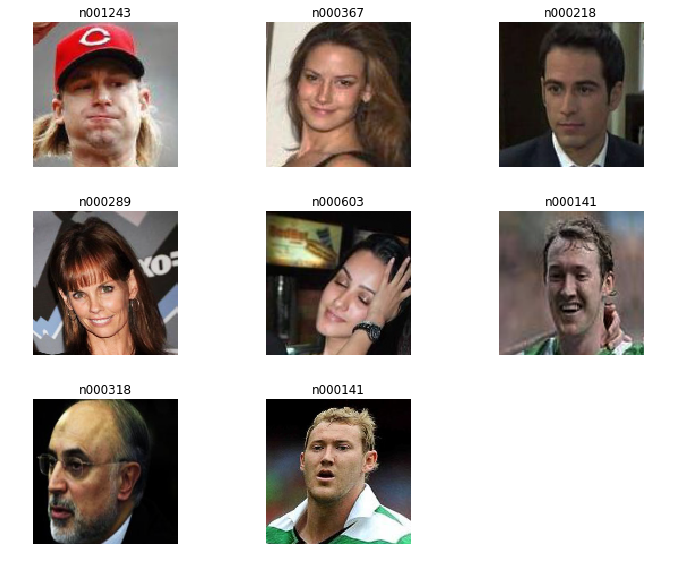

In [7]:
data.show_batch(nrows=4, figsize=(10,8))

In [8]:
#If needed
#torch.cuda.empty_cache()

In [9]:
arch = models.resnet50
arc_face_head = Customhead(num_classes = data.c)
custom_loss_func = ArcFaceLoss()
learn = cnn_learner(data, arch, custom_head=arc_face_head.head(), metrics=[accuracy])
learn.loss_func = custom_loss_func

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02


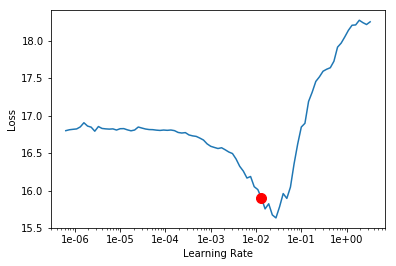

In [12]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [13]:
learn.fit_one_cycle(3,slice(1e-02))

epoch,train_loss,valid_loss,accuracy,time
0,8.638120,4.266280,0.864078,00:13
1,6.206745,2.807857,0.922330,00:12
2,4.242148,2.598048,0.912621,00:12


In [14]:
learn.save('Arcface_PlatFormAI_before_freeze')

In [19]:
#If needed
torch.cuda.empty_cache()

In [35]:
learn.load('Arcface_PlatFormAI_before_freeze')

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ArcMarginProduct. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ArcFaceLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (2060 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
n001243,n001243,n001243,n001243,n001243
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_platformai;

Valid: LabelList (515 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
n000367,n000318,n000603,n001243,n000289
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_platformai;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04


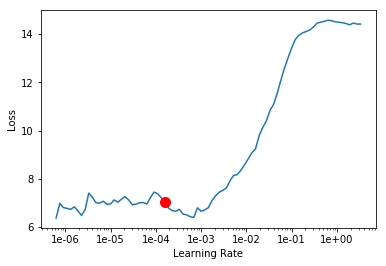

In [36]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [37]:
Jlearn.unfreeze()

In [38]:
learn.fit_one_cycle(5,slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,5.323552,2.590164,0.930097,00:41
1,3.574235,2.424459,0.922330,00:41
2,3.009334,1.471836,0.951456,00:41
3,2.431956,1.365377,0.951456,00:41
4,2.217631,1.363729,0.949515,00:41


In [39]:
learn.save('Arcface_PlatFormAI')

## AdaCos on Train PlatformAI Dataset

In [40]:
data = ImageDataBunch.from_name_re(path_train_platformai, fnames, pat, bs=bs, ds_tfms = get_transforms(), size=224)

In [41]:
arch = models.resnet50
arc_face_head = Customhead(num_classes = data.c)
learn2 = cnn_learner(data, arch, custom_head=arc_face_head.head(), metrics=[accuracy])
learn2.loss_func = AdaCosLoss(num_classes=7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02


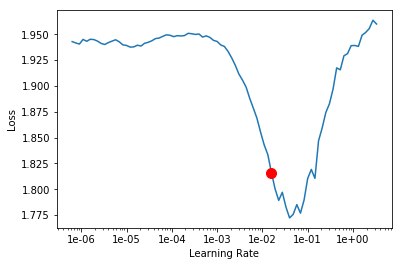

In [42]:
learn2.lr_find()
learn2.recorder.plot(suggestion=True)

In [43]:
learn2.fit_one_cycle(3,slice(1e-02))

epoch,train_loss,valid_loss,accuracy,time
0,0.984461,0.822334,0.873786,00:12
1,0.898699,0.791962,0.914563,00:11
2,0.840791,0.780066,0.926214,00:12


In [44]:
learn.save('AdaCos_PlatFormAI_before_freeze')

In [ ]:
learn.load('AdaCos_PlatFormAI_before_freeze')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


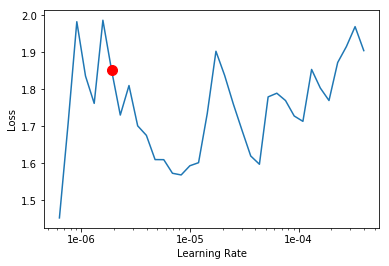

In [45]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [46]:
learn.unfreeze()

In [47]:
learn.fit_one_cycle(5,slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.324092,1.380859,0.959223,00:41
1,2.402190,1.194605,0.959223,00:41
2,1.715133,1.184586,0.959223,00:41
3,1.311874,0.960293,0.972816,00:41
4,1.222726,0.992668,0.974757,00:41


In [48]:
learn.save('AdaCos_PlatFormAI')

## ArcFace on Train 100 Dataset

In [80]:
fnames = get_image_files(path_train_100, recurse=True)
data = ImageDataBunch.from_name_re(path_train_100, fnames, pat, bs=bs, ds_tfms = get_transforms(), size=224)

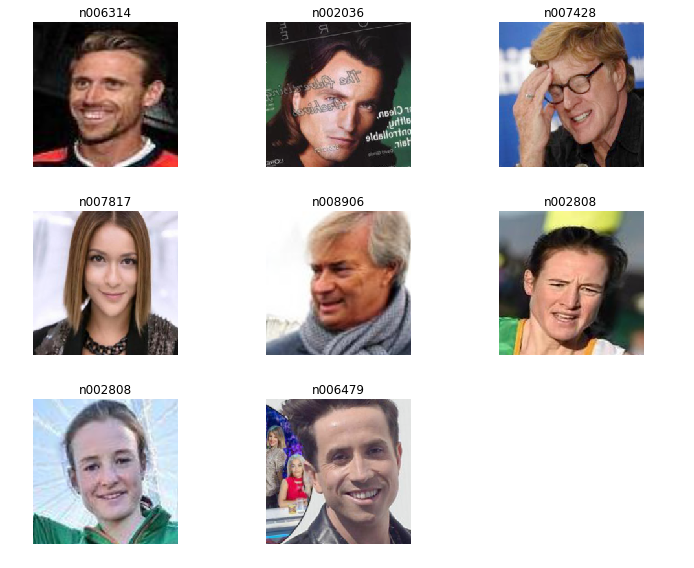

In [81]:
data.show_batch(nrows=4, figsize=(10,8))

In [82]:
#If needed
#torch.cuda.empty_cache()

In [83]:
arch = models.resnet50
arc_face_head = Customhead(num_classes = data.c)
custom_loss_func = ArcFaceLoss()
learn3 = cnn_learner(data, arch, custom_head=arc_face_head.head(), metrics=[accuracy])
learn3.loss_func = custom_loss_func

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06


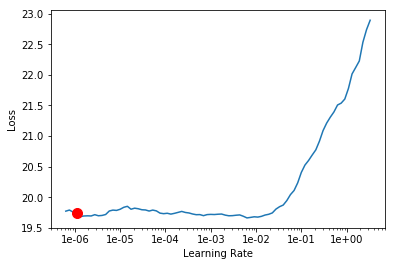

In [84]:
learn3.lr_find()
learn3.recorder.plot(suggestion=True)

In [85]:
learn.fit_one_cycle(4, slice(1e-2/2))

epoch,train_loss,valid_loss,accuracy,time
0,15.542385,13.043666,0.554548,05:37
1,11.697774,9.001060,0.670651,05:37
2,10.016077,7.829489,0.700742,05:37
3,9.376039,7.527687,0.705688,05:36


In [86]:
learn3.save('Arcface_Train100_before_freeze')

In [ ]:
#If needed
#torch.cuda.empty_cache()

In [94]:
learn3.load('Arcface_Train100_before_freeze')

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ArcMarginProduct. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ArcFaceLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (29116 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n004159,n004159,n004159,n004159,n004159
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_100;

Valid: LabelList (7278 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n009168,n000289,n001051,n008310,n003584
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_100;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


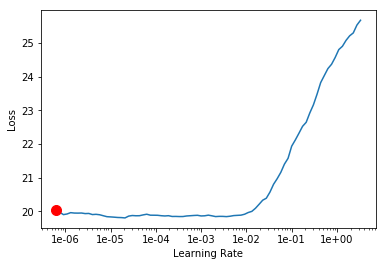

In [95]:
learn3.lr_find()
learn3.recorder.plot(suggestion=True)

In [96]:
learn3.unfreeze()

In [97]:
learn3.fit_one_cycle(10,slice(1e-06,1e-02))

epoch,train_loss,valid_loss,accuracy,time
0,14.085537,11.223764,0.629706,09:27
1,10.886379,8.086058,0.716680,08:22
2,8.602860,6.661232,0.758588,08:23
3,7.006845,4.736267,0.833608,08:23
4,5.759919,3.643486,0.870981,08:24
5,4.398568,3.027836,0.890080,08:23
6,3.021167,2.289490,0.920170,08:24
7,1.980080,1.860057,0.936658,08:25
8,1.587164,1.634832,0.943116,08:25
9,1.182245,1.551750,0.946414,08:24


In [98]:
learn3.save('Arcface_Train100')

## AdaCoss on Train 100 Dataset

In [99]:
fnames = get_image_files(path_train_100, recurse=True)
data = ImageDataBunch.from_name_re(path_train_100, fnames, pat, bs=bs, ds_tfms = get_transforms(), size=224)

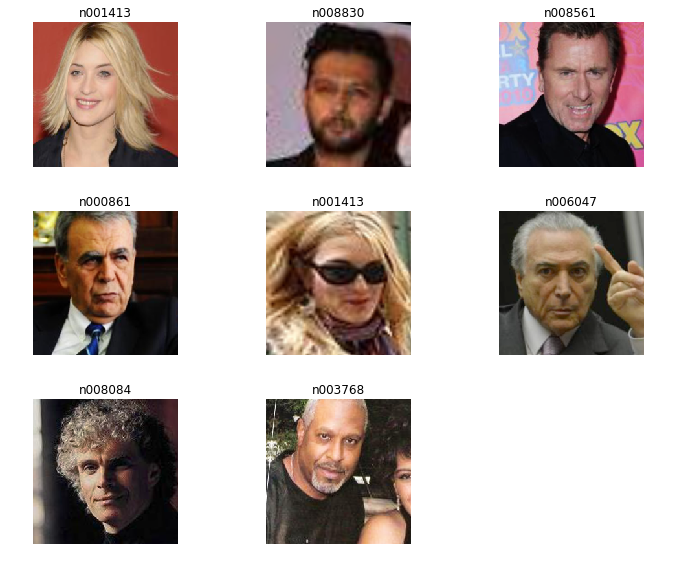

In [100]:
data.show_batch(nrows=4, figsize=(10,8))

In [101]:
#If needed
#torch.cuda.empty_cache()

In [102]:
arch = models.resnet50
arc_face_head = Customhead(num_classes = data.c)
learn4 = cnn_learner(data, arch, custom_head=arc_face_head.head(), metrics=[accuracy])
learn4.loss_func = AdaCosLoss(num_classes=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


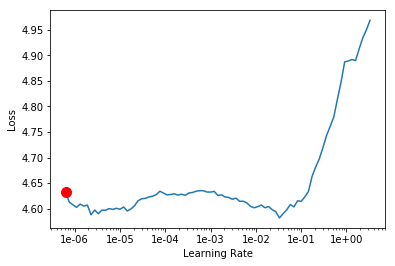

In [103]:
learn4.lr_find()
learn4.recorder.plot(suggestion=True)

In [104]:
learn4.fit_one_cycle(4, slice(1e-2/2))

epoch,train_loss,valid_loss,accuracy,time
0,2.181363,1.631749,0.576944,05:38
1,1.695883,1.251280,0.719841,05:38
2,1.444683,1.146620,0.781259,05:38
3,1.379834,1.128777,0.796785,05:38


In [105]:
learn4.save('AdaCoss_Train100_before_freeze')

In [106]:
#If needed
#torch.cuda.empty_cache()

In [107]:
learn4.load('AdaCoss_Train100_before_freeze')

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ArcMarginProduct. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AdaCosLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (29116 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n004159,n004159,n004159,n004159,n004159
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_100;

Valid: LabelList (7278 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n004255,n006314,n006949,n001413,n007890
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_100;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


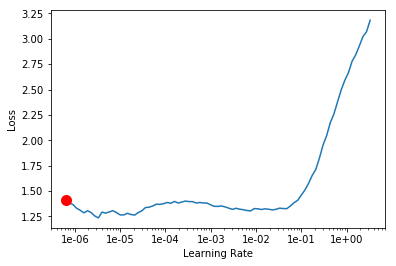

In [108]:
learn4.lr_find()
learn4.recorder.plot(suggestion=True)

In [109]:
learn4.unfreeze()

In [110]:
learn4.fit_one_cycle(10,slice(1e-06,1e-02))

epoch,train_loss,valid_loss,accuracy,time
0,1.306401,1.086638,0.816433,08:25
1,1.293717,1.086068,0.814097,08:25
2,1.237813,1.054116,0.840066,08:26
3,1.105267,1.010941,0.875790,08:26
4,1.024520,0.938292,0.913026,08:26
5,0.953867,0.897112,0.929101,08:26
6,0.881476,0.873678,0.939956,08:26
7,0.831351,0.837924,0.953009,08:26
8,0.795967,0.823604,0.957131,08:25
9,0.754545,0.822747,0.957131,08:26


In [111]:
learn4.save('AdaCoss_Train100')

## Infos learner

In [112]:
data.c

100

In [113]:
learn4.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [114]:
print(learn4.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________